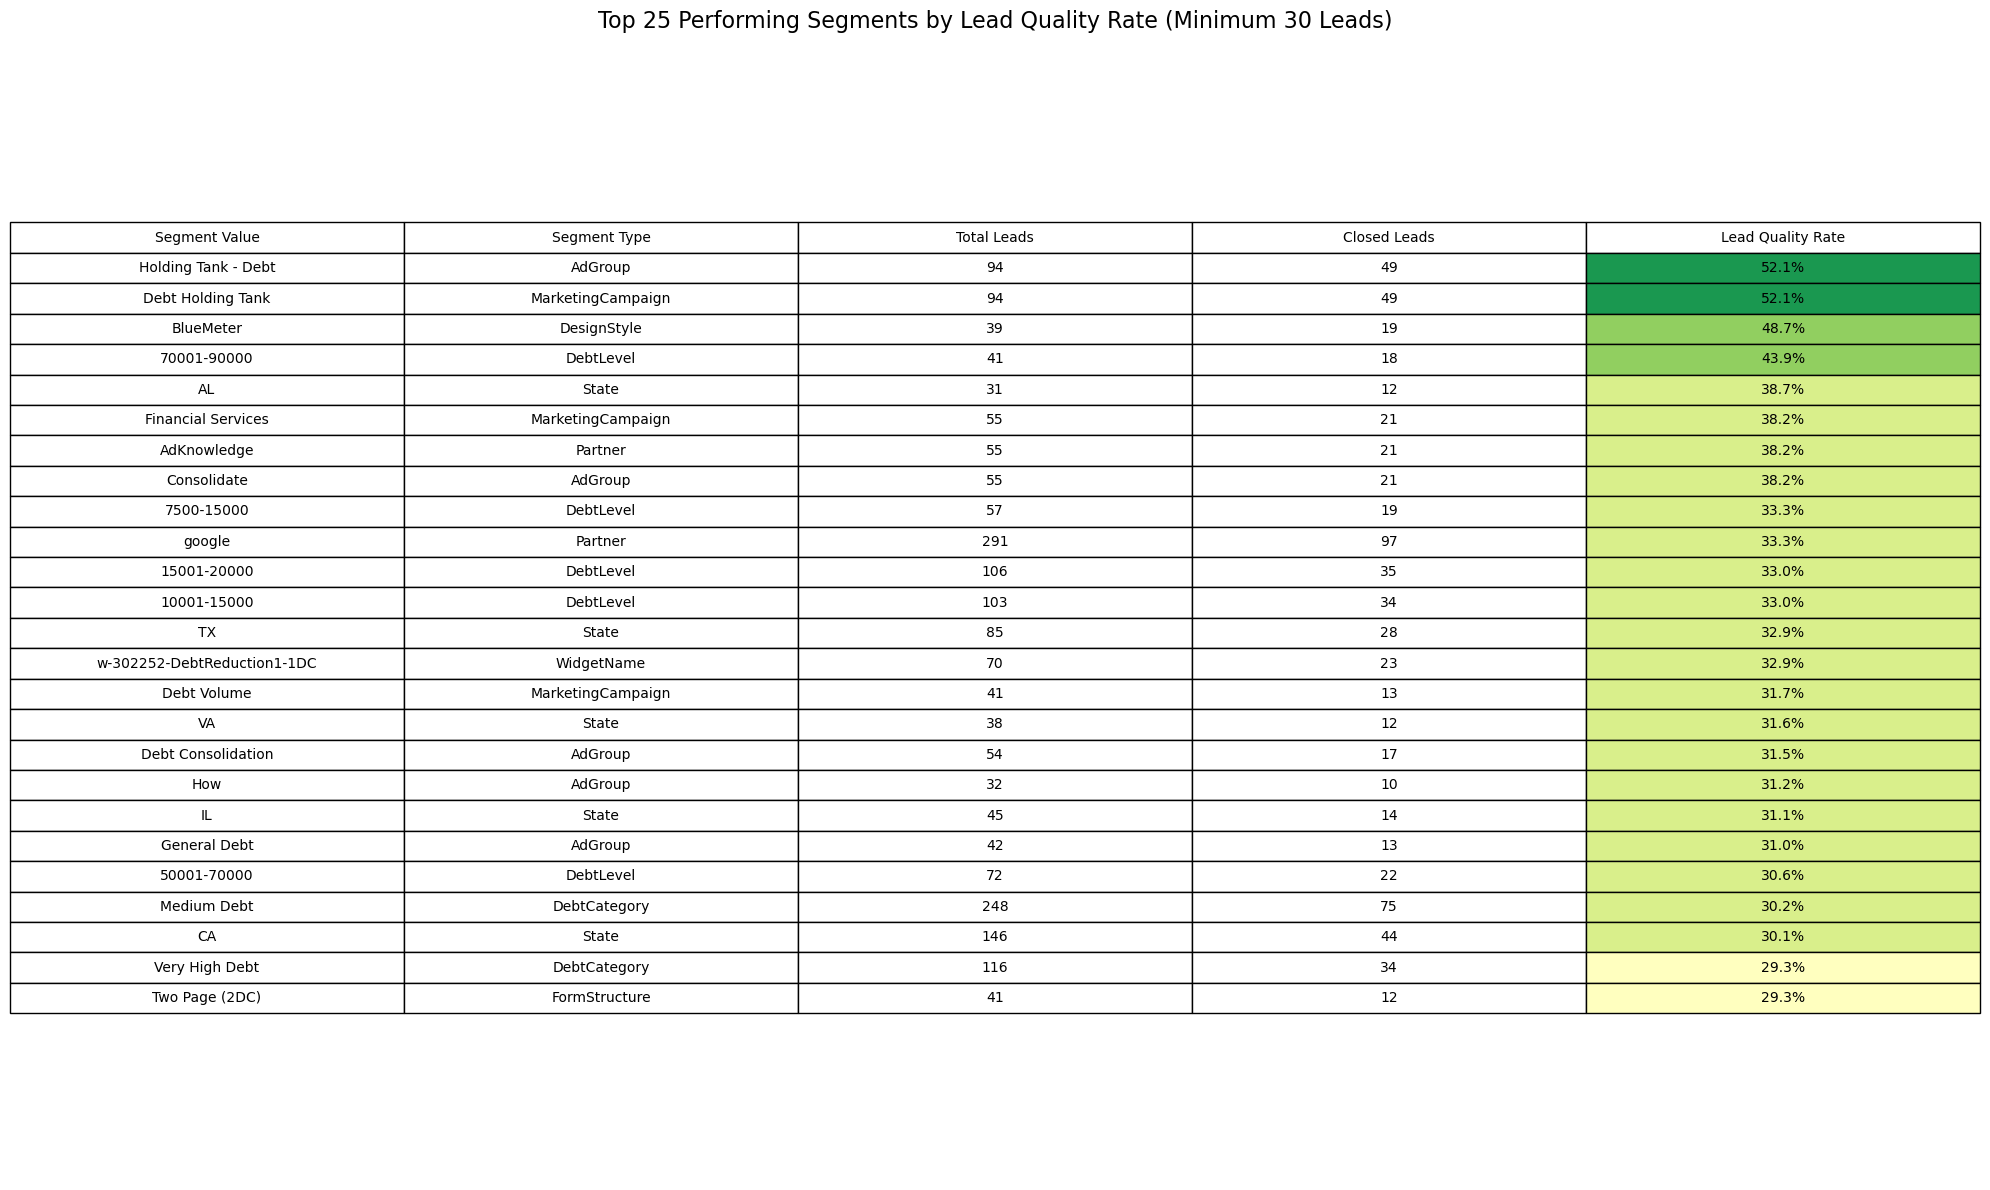

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def create_top_segments_table(file_path, min_sample_size=30, num_segments=25):
    """Create a table of top performing segments by lead quality rate.
    
    Parameters:
    -----------
    file_path : str
        Path to the Excel file containing the data
    min_sample_size : int
        Minimum number of leads required for a segment to be included
    num_segments : int
        Number of top segments to include in the table
    """
    # Read the dataset
    df = pd.read_excel(file_path)
    
    # Filter to only include rows with CallStatus
    with_status = df[df['CallStatus'].notna()]
    
    # Add derived columns for better analysis
    
    # Extract widget features
    with_status['FormStructure'] = 'Unknown'
    with_status.loc[with_status['WidgetName'].str.contains('-1DC', na=False), 'FormStructure'] = 'Single Page (1DC)'
    with_status.loc[with_status['WidgetName'].str.contains('-2DC', na=False), 'FormStructure'] = 'Two Page (2DC)'
    
    with_status['DesignStyle'] = 'Basic'
    style_patterns = {
        'CreditSolutions': 'CreditSolutions',
        'yellowarrow': 'YellowArrow',
        'BlueMeter': 'BlueMeter',
        'Head2': 'Head2',
        'Head3': 'Head3',
        'white': 'White'
    }
    for pattern, style in style_patterns.items():
        with_status.loc[with_status['WidgetName'].str.contains(pattern, na=False), 'DesignStyle'] = style
    
    # Group debt levels into categories
    debt_categories = {
        'Low Debt': ['7500-10000', '7500-15000', '10001-15000'],
        'Medium Debt': ['15001-20000', '20001-30000'],
        'High Debt': ['30001-50000', '50001-70000'],
        'Very High Debt': ['70001-90000', '90000-100000', 'More_than_100000']
    }
    
    with_status['DebtCategory'] = 'Unknown'
    for category, levels in debt_categories.items():
        with_status.loc[with_status['DebtLevel'].isin(levels), 'DebtCategory'] = category
    
    # Create information quality segments
    with_status['InfoQuality'] = 'Lower Info Quality'
    with_status.loc[(with_status['AddressScore'] == 5) | (with_status['PhoneScore'] == 5), 'InfoQuality'] = 'High Info Quality'
    
    # List of segments to analyze
    segment_columns = [
        'DebtLevel', 'Partner', 'PublisherZoneName', 'WidgetName', 'AdGroup', 
        'State', 'PhoneScore', 'AddressScore', 'MarketingCampaign',
        'FormStructure', 'DesignStyle', 'DebtCategory', 'InfoQuality'
    ]
    
    top_segments = []
    
    # Analyze each segment type
    for column in segment_columns:
        if column in with_status.columns:
            segment_data = with_status.groupby(column).agg(
                total=('CallStatus', 'count'),
                closed=('CallStatus', lambda x: (x == 'Closed').sum()),
            ).reset_index()
            
            segment_data['closed_rate'] = segment_data['closed'] / segment_data['total'] * 100
            segment_data['segment_type'] = column
            
            # Only include segments with sufficient sample size
            segment_data = segment_data[segment_data['total'] >= min_sample_size]
            segment_data.rename(columns={column: 'segment_value'}, inplace=True)
            
            # Select only the columns we need
            segment_data = segment_data[['segment_value', 'segment_type', 'total', 'closed', 'closed_rate']]
            top_segments.append(segment_data)
    
    # Combine all segments
    if top_segments:
        all_segments = pd.concat(top_segments)
        
        # Get top segments by lead quality rate
        top_performers = all_segments.sort_values('closed_rate', ascending=False).head(num_segments)
        
        # Create a figure for the table
        fig, ax = plt.subplots(figsize=(20, 12))
        ax.axis('tight')
        ax.axis('off')
        
        # Prepare the table data with percentages
        table_data = []
        for _, row in top_performers.iterrows():
            table_data.append([
                row['segment_value'],
                row['segment_type'],
                int(row['total']),
                int(row['closed']),
                f"{row['closed_rate']:.1f}%"
            ])
        
        # Create the table
        table = ax.table(
            cellText=table_data,
            colLabels=['Segment Value', 'Segment Type', 'Total Leads', 'Closed Leads', 'Lead Quality Rate'],
            loc='center',
            cellLoc='center'
        )
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        
        # Color coding based on lead quality rate
        for i, row in enumerate(table_data):
            rate = float(row[4].strip('%'))
            
            # Set cell colors based on lead quality rate
            if rate >= 50:
                color = '#1a9850'  # Dark green
            elif rate >= 40:
                color = '#91cf60'  # Green
            elif rate >= 30:
                color = '#d9ef8b'  # Light green
            else:
                color = '#ffffbf'  # Light yellow
            
            # Apply color to the lead quality rate cell
            table[(i+1, 4)].set_facecolor(color)
        
        # Add a title
        plt.title(f'Top {num_segments} Performing Segments by Lead Quality Rate (Minimum {min_sample_size} Leads)', 
                 fontsize=16, pad=20)
        
        plt.tight_layout()
        plt.savefig('top_segments_table.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Return the dataframe for additional analysis or export
        return top_performers
    else:
        print("No segments with sufficient data found.")
        return None

# Example usage
if __name__ == "__main__":
    # Replace with your actual file path
    file_path = "Aarki.xlsx"
    top_segments = create_top_segments_table(file_path, min_sample_size=30, num_segments=25)


Creating performance table for: Marketing Campaign


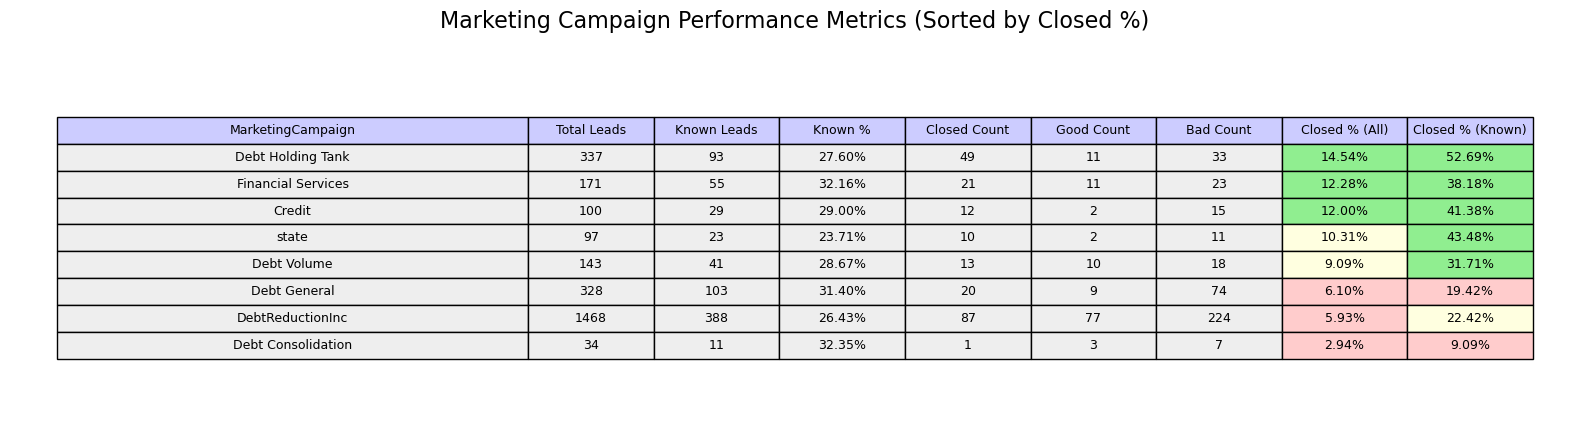

Creating bar chart for Marketing Campaign
Column names available: ['MarketingCampaign', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


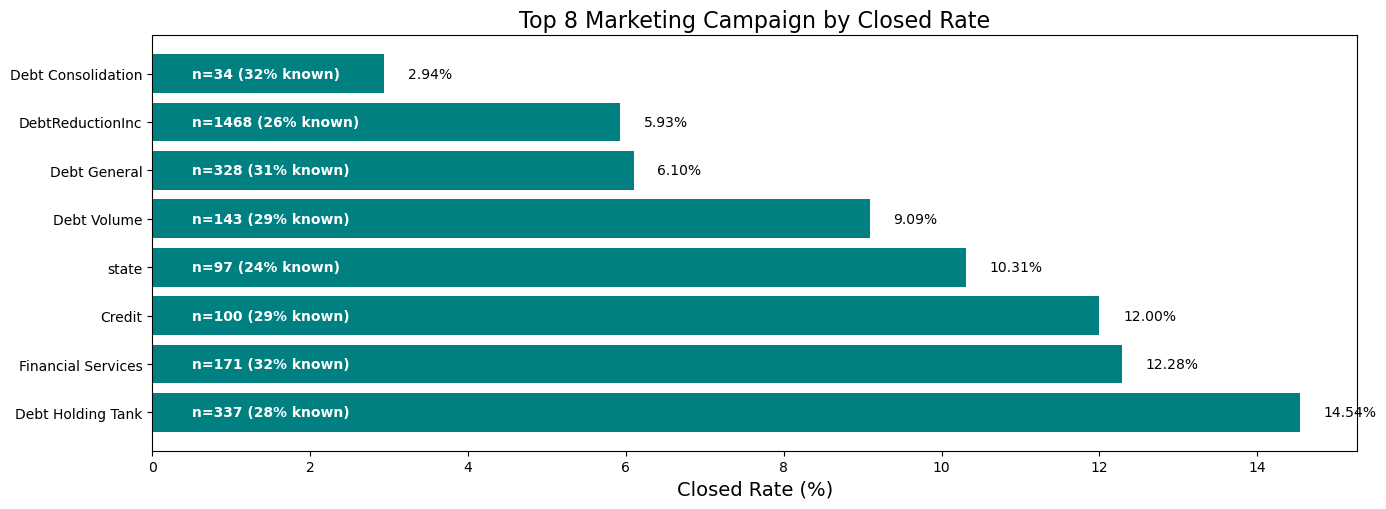


Creating performance table for: State


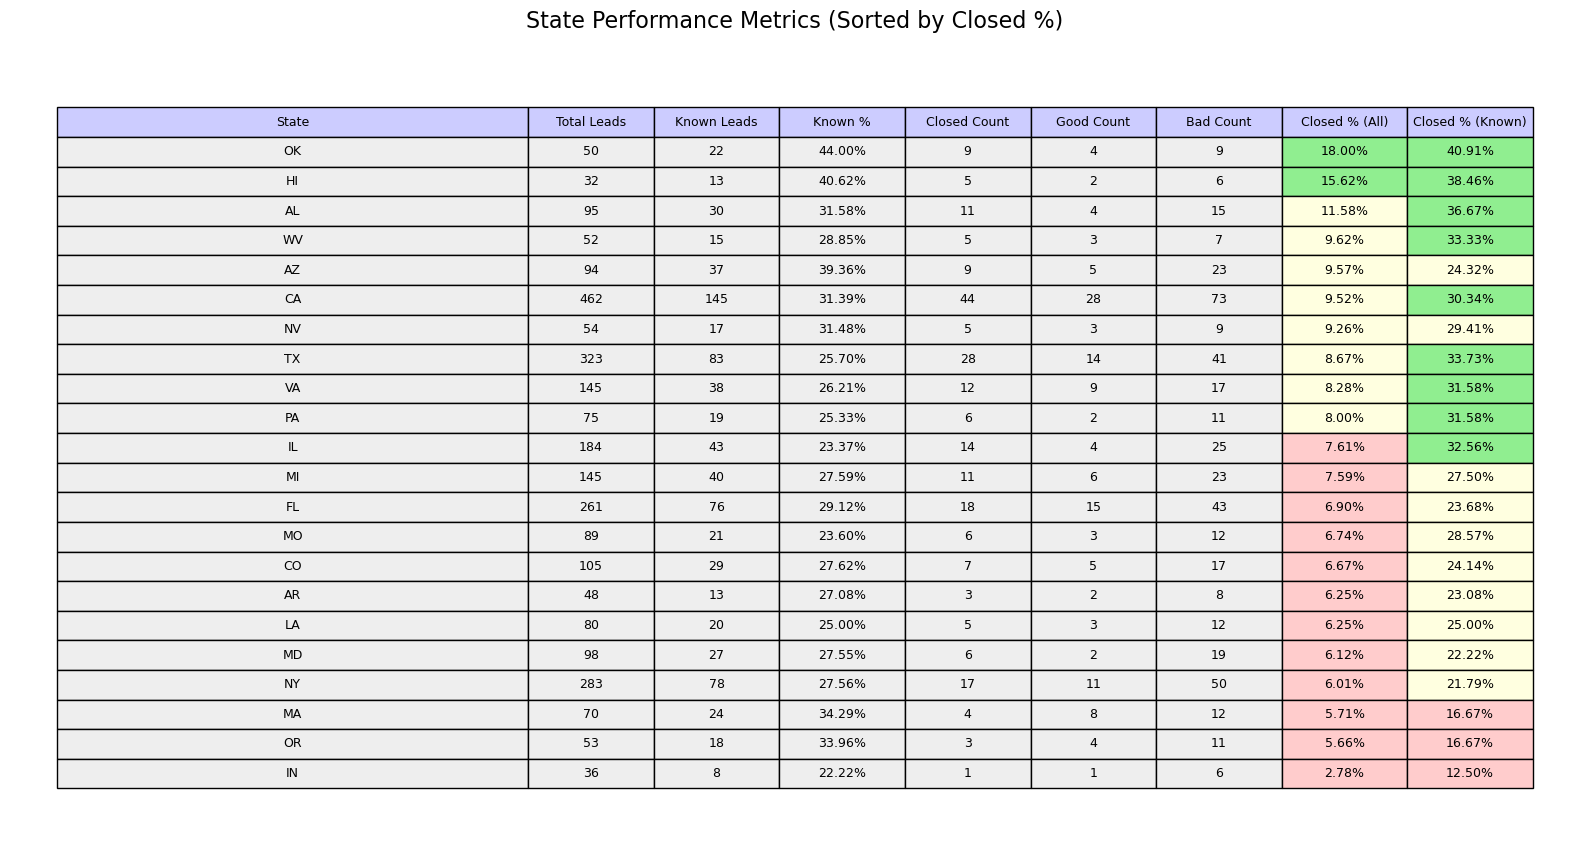

Creating bar chart for State
Column names available: ['State', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


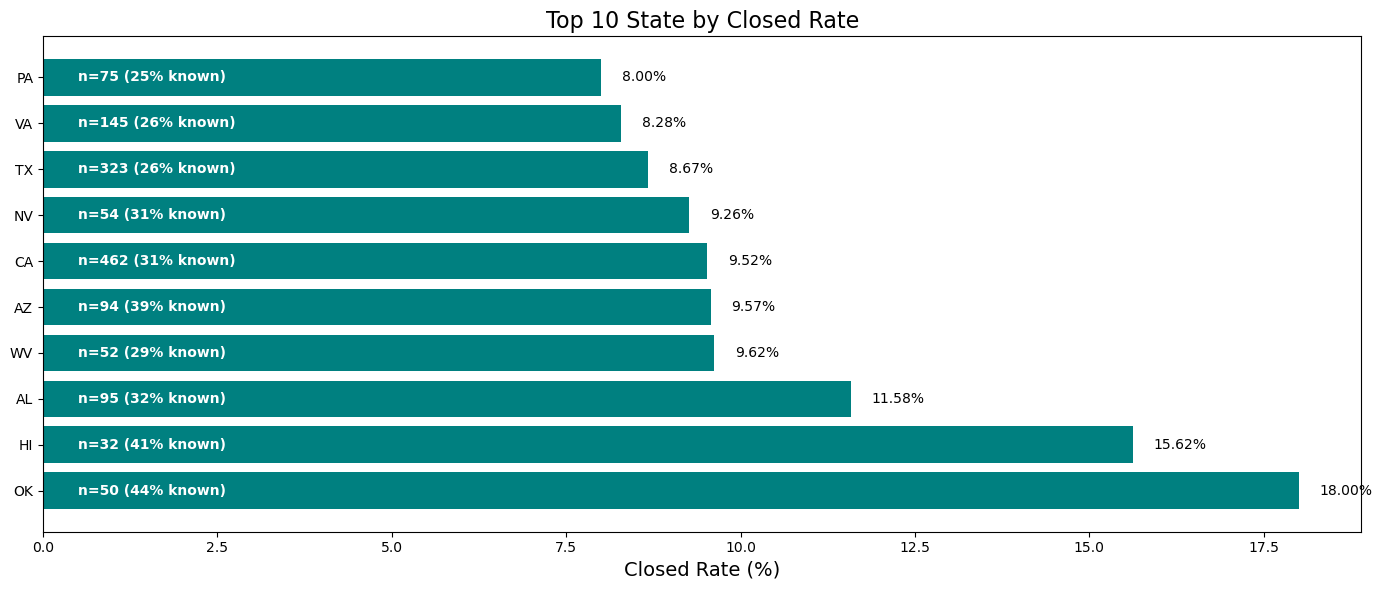


Creating performance table for: Debt Level


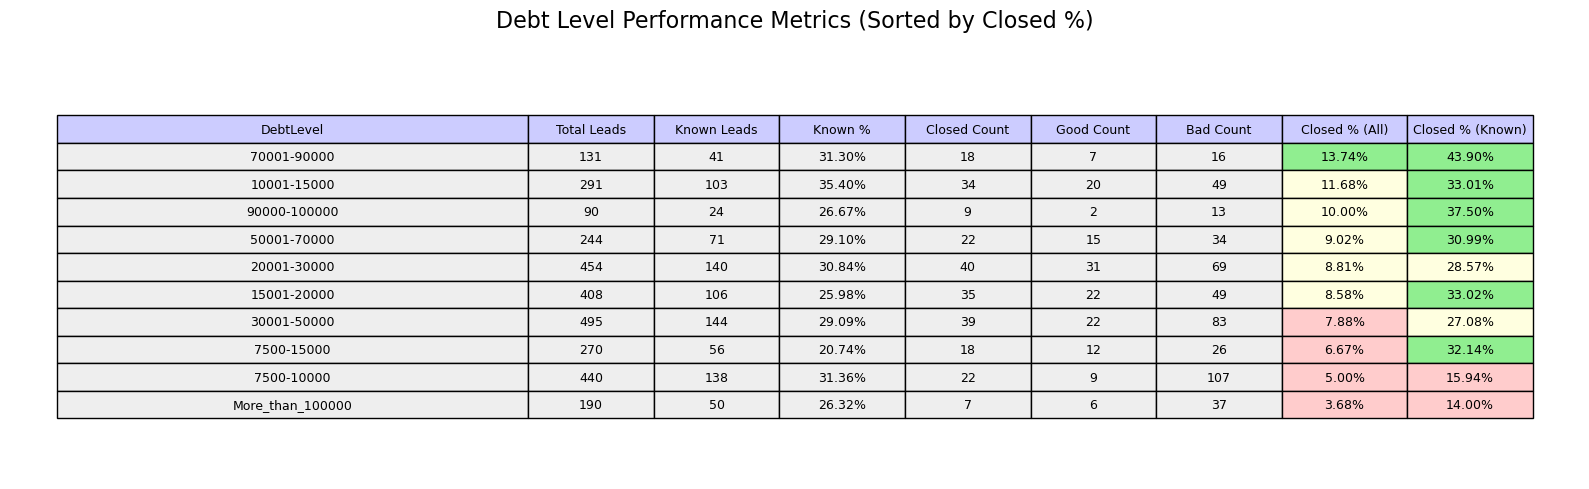

Creating bar chart for Debt Level
Column names available: ['DebtLevel', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


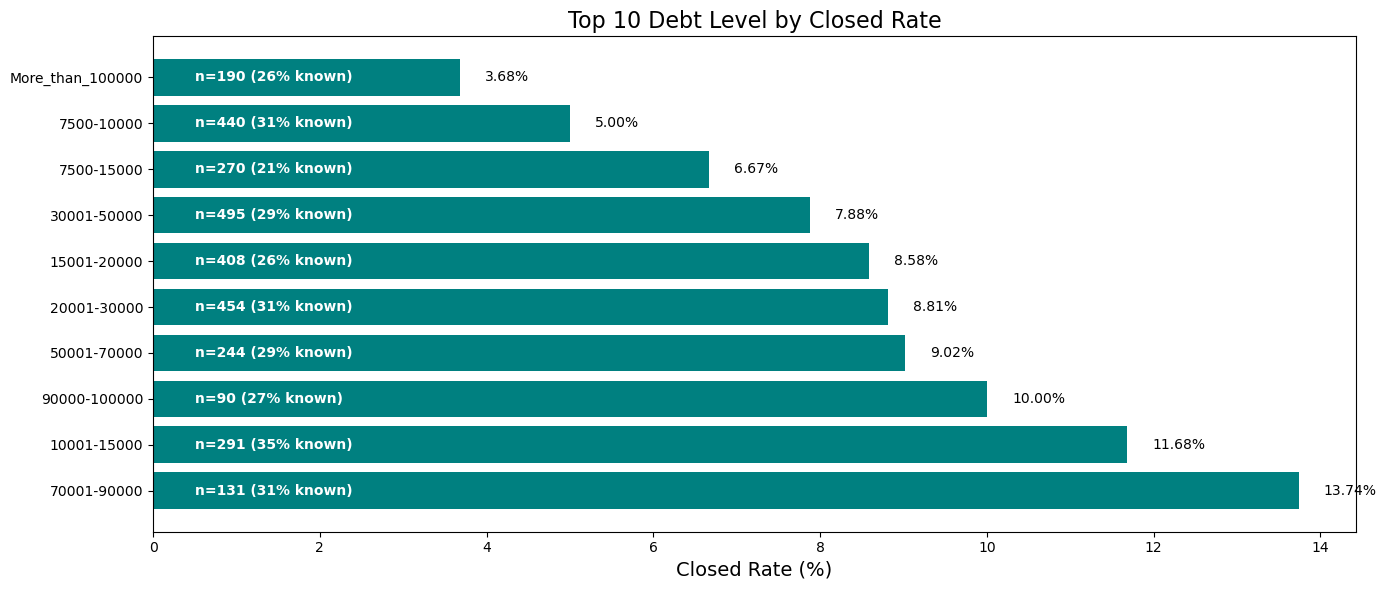


Creating performance table for: Partner


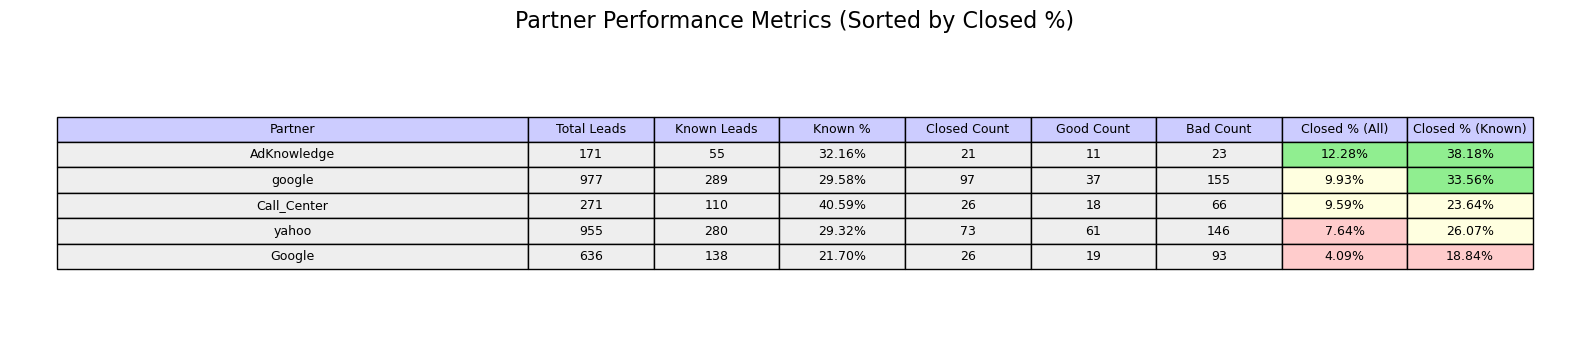

Creating bar chart for Partner
Column names available: ['Partner', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


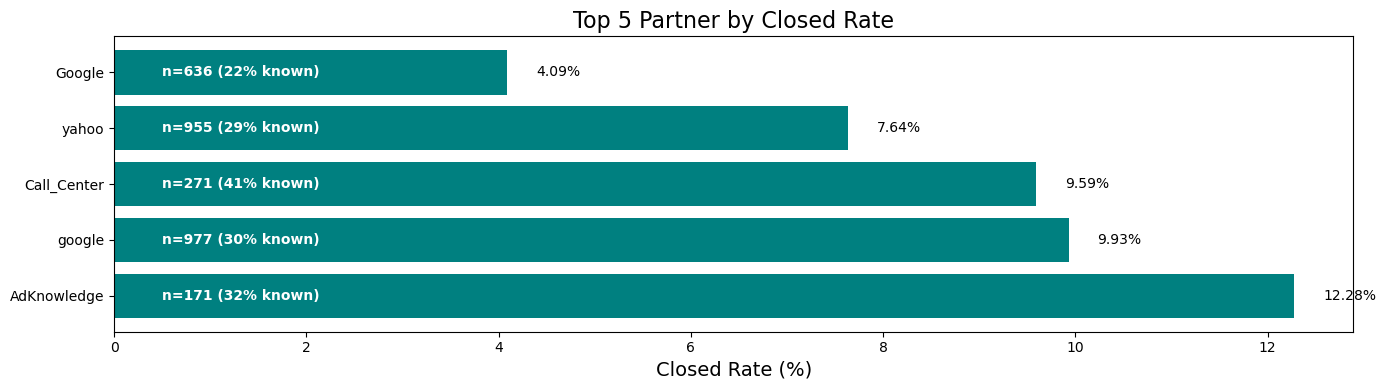


Creating performance table for: Ad Group


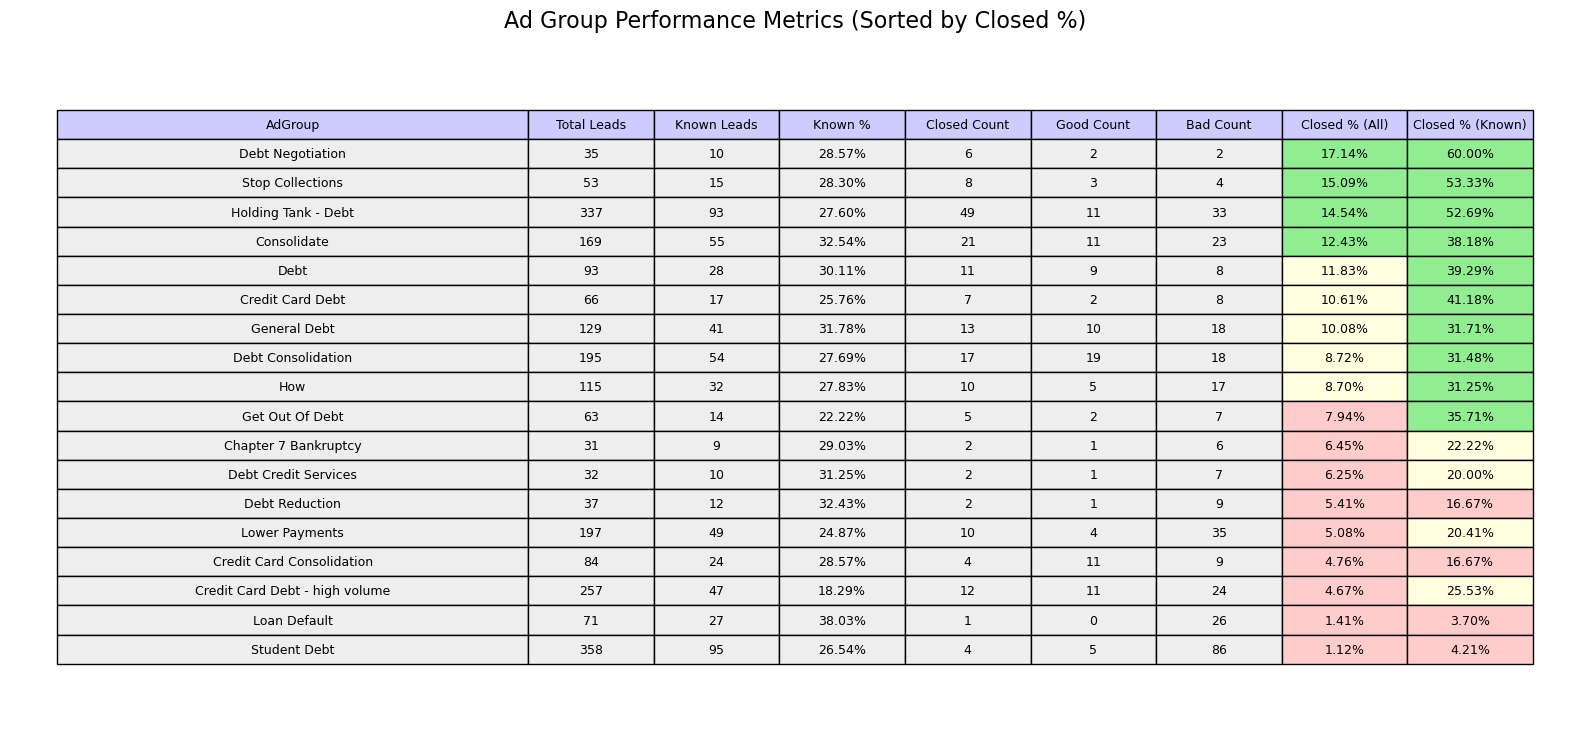

Creating bar chart for Ad Group
Column names available: ['AdGroup', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


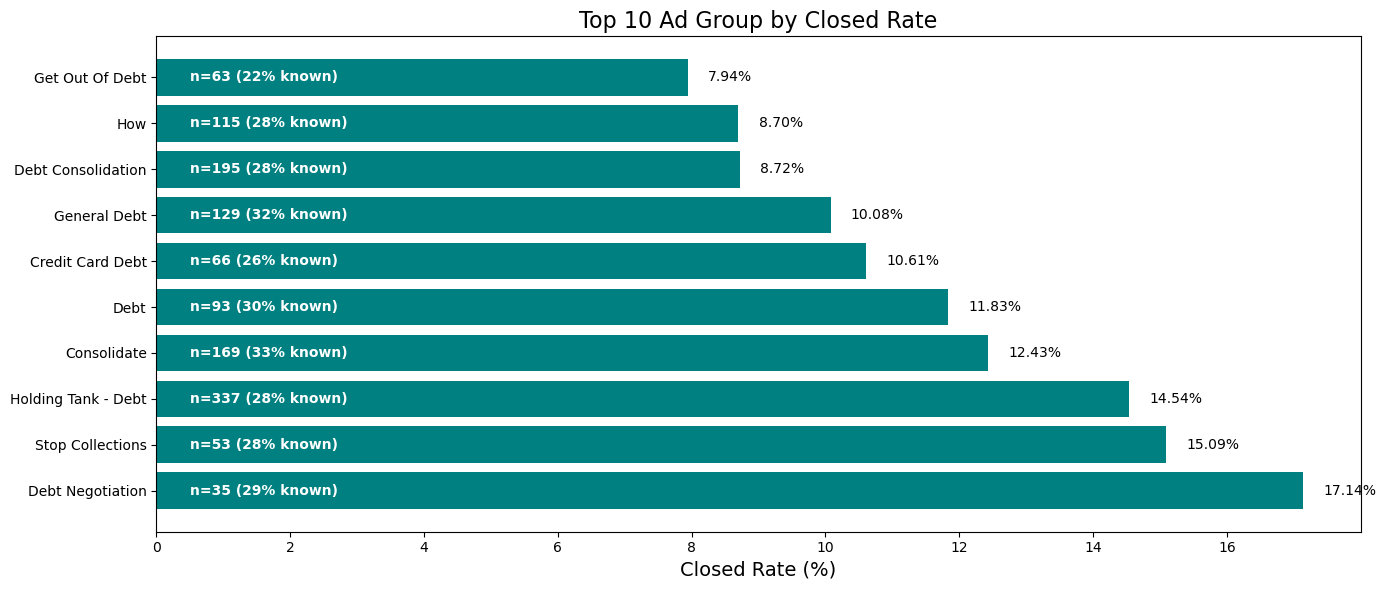


Creating performance table for: Information Quality


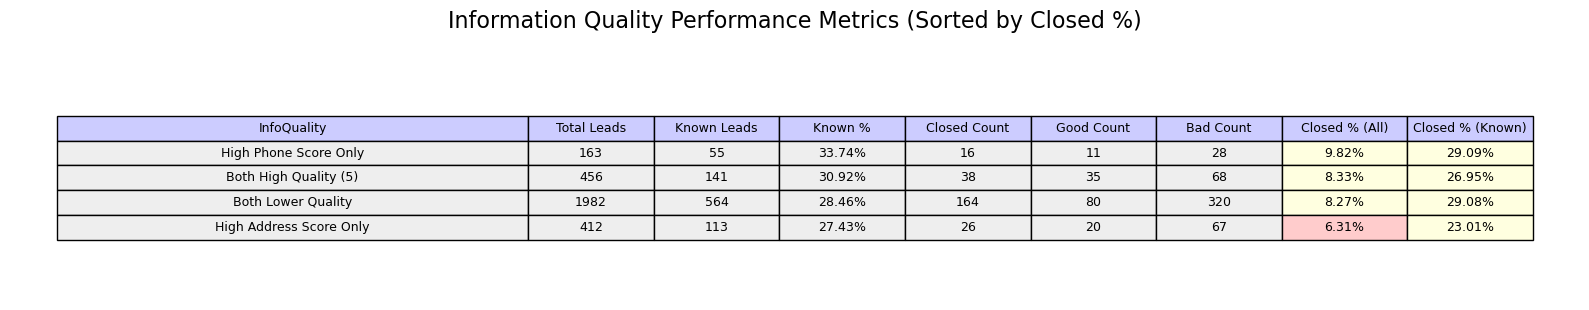

Creating bar chart for Information Quality
Column names available: ['InfoQuality', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


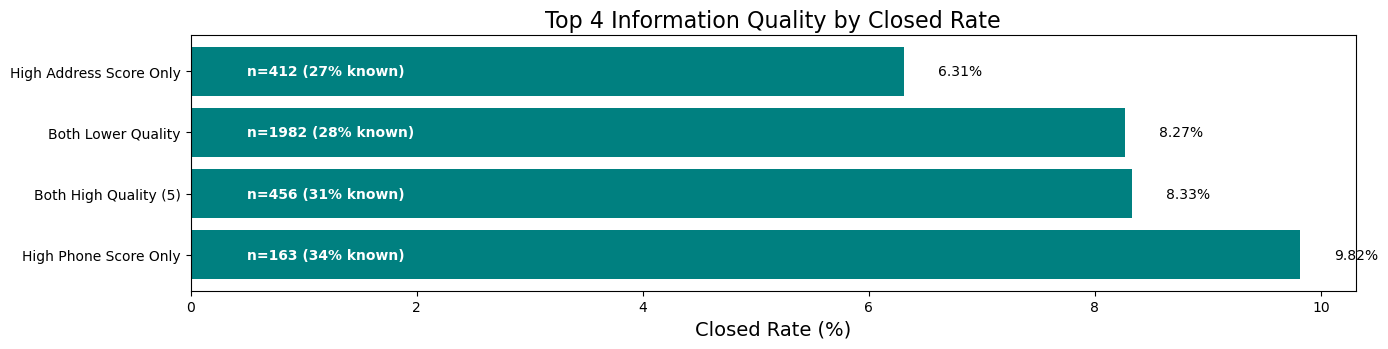


Creating performance table for: Publisher Zone


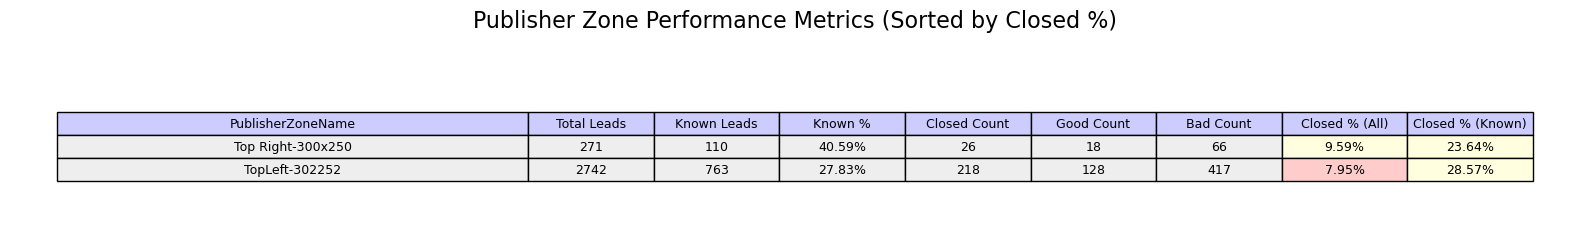

Creating bar chart for Publisher Zone
Column names available: ['PublisherZoneName', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


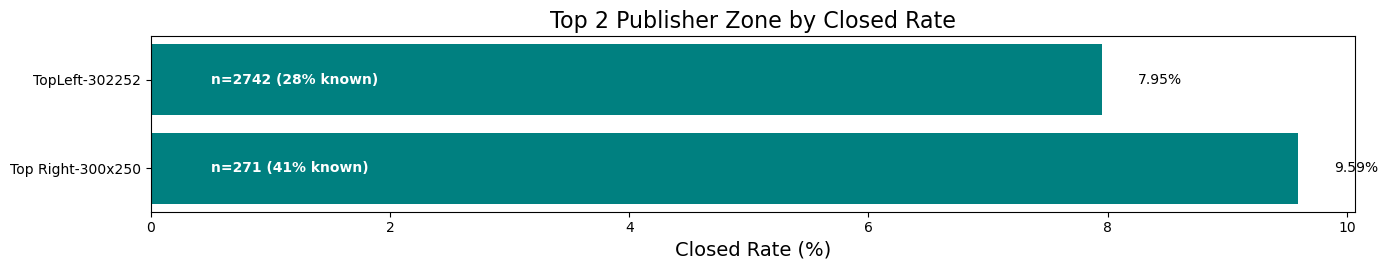


Creating performance table for: Phone Score


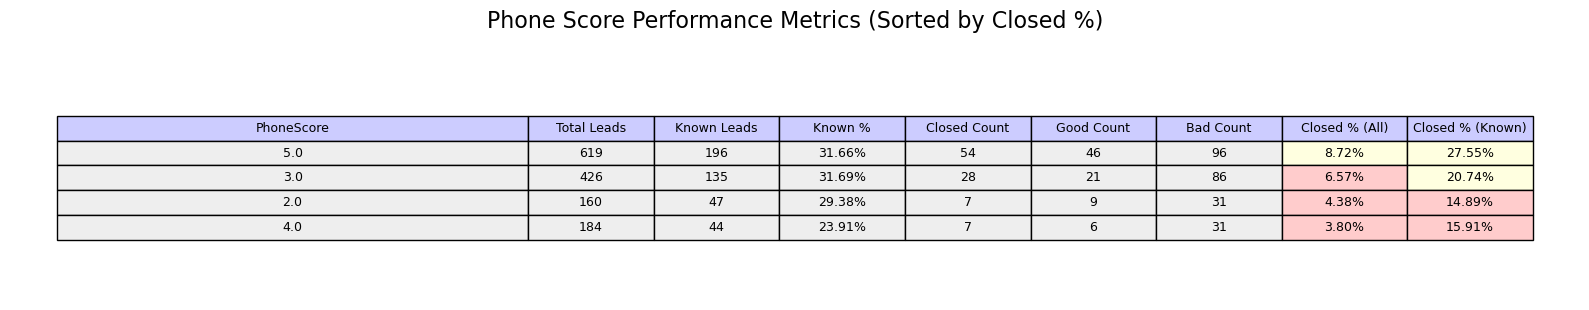

Creating bar chart for Phone Score
Column names available: ['PhoneScore', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


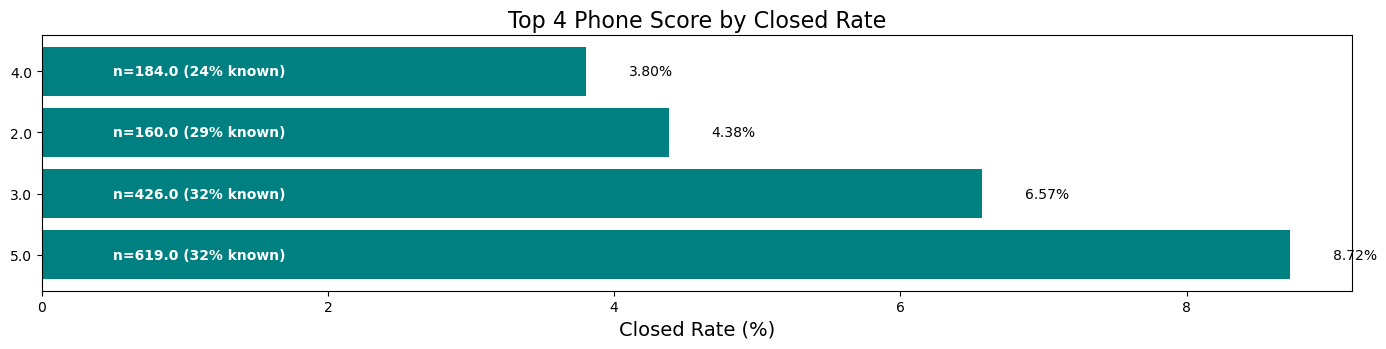


Creating performance table for: Widget Name


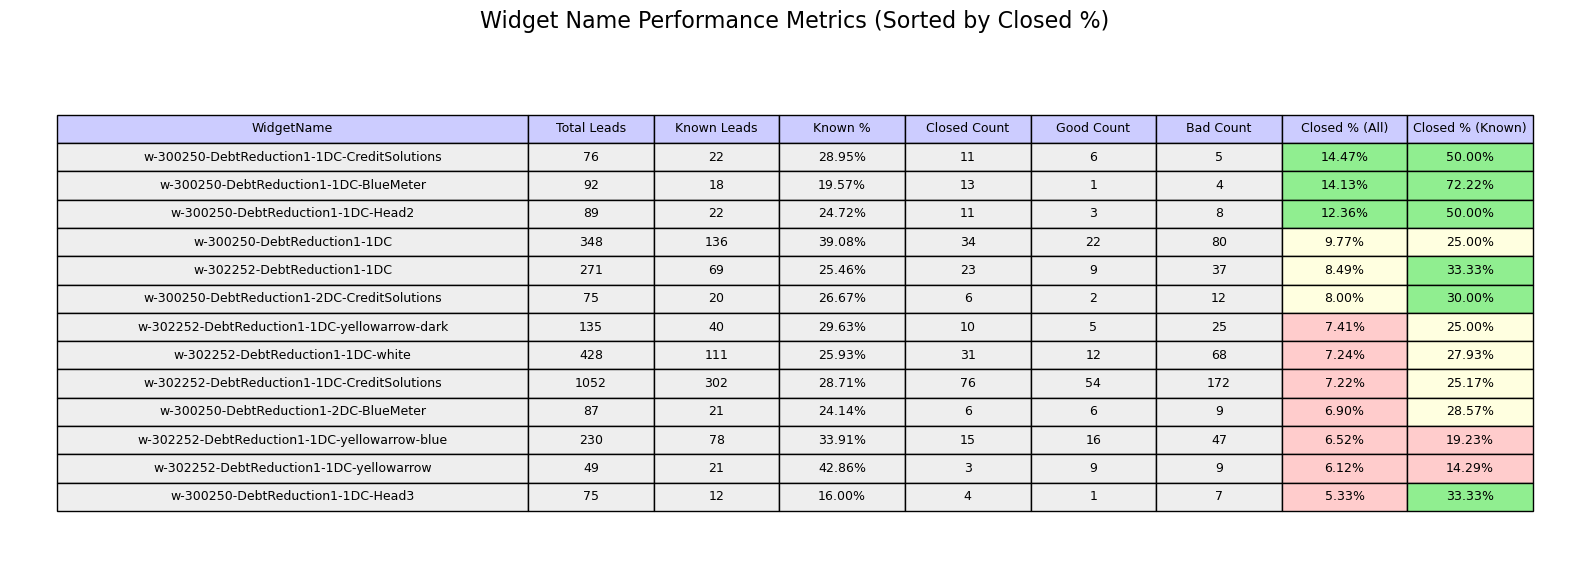

Creating bar chart for Widget Name
Column names available: ['WidgetName', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


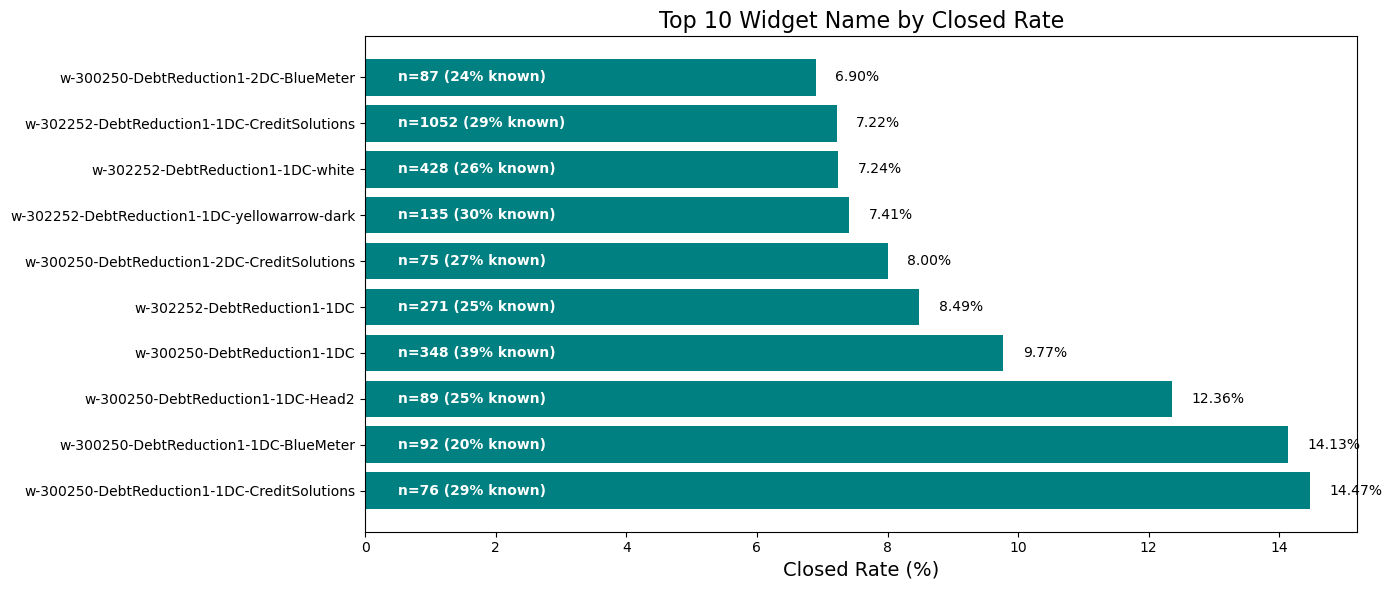


Creating performance table for: Address Score


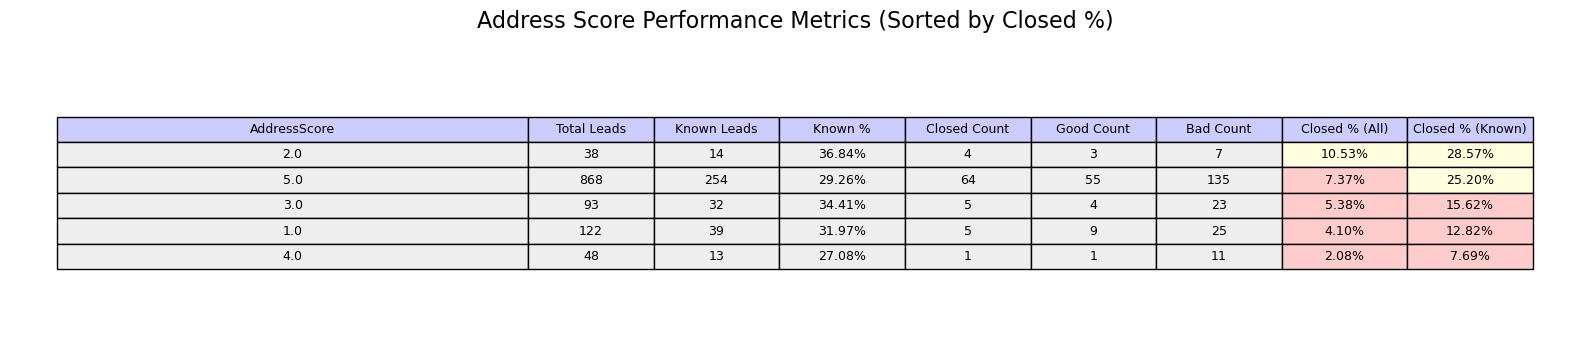

Creating bar chart for Address Score
Column names available: ['AddressScore', 'Total Leads', 'Known Leads', 'Known %', 'Closed Count', 'Good Count', 'Bad Count', 'Closed % (All)', 'Closed % (Known)']


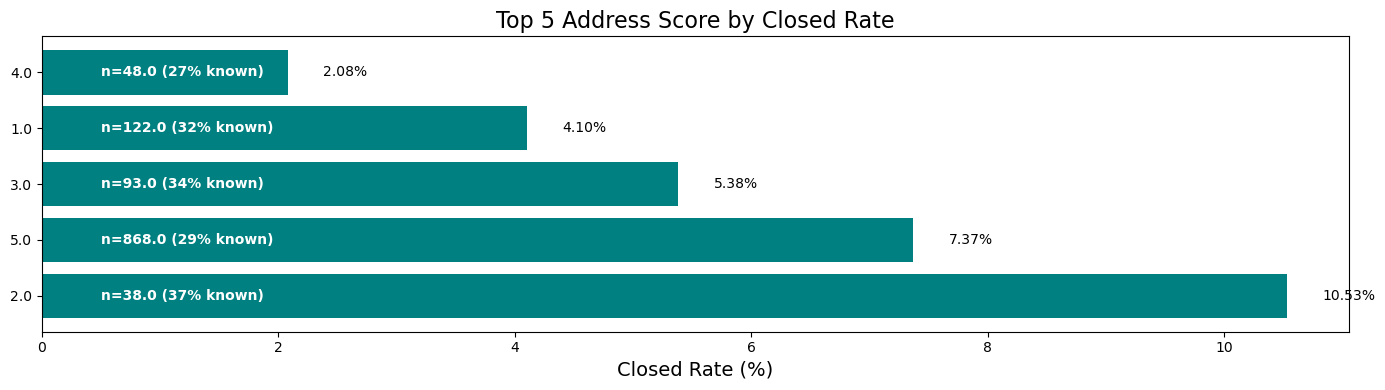

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_dimension_performance_tables(file_path):
    """
    Creates performance pivot tables for multiple dimensions in the dataset
    """
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Define a function to categorize CallStatus
    def categorize_call_status(status):
        if pd.isna(status):
            return 'Unknown'
        if status == 'Closed':
            return 'Closed'
        if status in ['EP Sent', 'EP Received', 'EP Confirmed']:
            return 'Good Quality'
        if status in ['Unable to contact - Bad Contact Information', 'Contacted - Invalid Profile', "Contacted - Doesn't Qualify"]:
            return 'Bad Quality'
        return 'Unknown'
    
    # Add quality category
    df['QualityCategory'] = df['CallStatus'].apply(categorize_call_status)
    
    # Add info quality (combination of address and phone scores)
    df['InfoQuality'] = 'Unknown'
    df.loc[(df['AddressScore'] == 5) & (df['PhoneScore'] == 5), 'InfoQuality'] = 'Both High Quality (5)'
    df.loc[(df['AddressScore'] == 5) & ((df['PhoneScore'] != 5) | pd.isna(df['PhoneScore'])), 'InfoQuality'] = 'High Address Score Only'
    df.loc[(df['PhoneScore'] == 5) & ((df['AddressScore'] != 5) | pd.isna(df['AddressScore'])), 'InfoQuality'] = 'High Phone Score Only'
    df.loc[((df['AddressScore'] != 5) | pd.isna(df['AddressScore'])) & 
          ((df['PhoneScore'] != 5) | pd.isna(df['PhoneScore'])) & 
          (df['InfoQuality'] == 'Unknown'), 'InfoQuality'] = 'Both Lower Quality'
    
    # Function to create pivot table for a specific dimension
    def create_pivot_for_dimension(df, dimension_name, min_leads=30):
        """
        Creates a pivot table for a specific dimension, showing counts and rates
        """
        # Group by dimension
        pivot = pd.pivot_table(
            df, 
            index=dimension_name,
            aggfunc={'VendorLeadID': 'count'}  # Using VendorLeadID for counting since it's the unique key
        ).rename(columns={'VendorLeadID': 'Total_Leads'})
        
        # Add counts for each quality category
        for category in ['Closed', 'Good Quality', 'Bad Quality', 'Unknown']:
            category_count = df[df['QualityCategory'] == category].pivot_table(
                index=dimension_name,
                aggfunc={'VendorLeadID': 'count'}
            ).rename(columns={'VendorLeadID': f'{category}_Count'})
            
            # Join with main pivot table
            pivot = pivot.join(category_count, how='left')
        
        # Fill NA values with 0
        pivot = pivot.fillna(0)
        
        # Calculate metrics
        pivot['Known_Leads'] = pivot['Closed_Count'] + pivot['Good Quality_Count'] + pivot['Bad Quality_Count']
        pivot['Known_Pct'] = pivot['Known_Leads'] / pivot['Total_Leads'] * 100
        pivot['Closed_Pct_All'] = pivot['Closed_Count'] / pivot['Total_Leads'] * 100
        pivot['Closed_Pct_Known'] = pivot['Closed_Count'] / pivot['Known_Leads'] * 100
        pivot.loc[pivot['Known_Leads'] == 0, 'Closed_Pct_Known'] = 0  # Avoid division by zero
        
        # Select and reorder columns
        pivot = pivot[[
            'Total_Leads', 'Known_Leads', 'Known_Pct',
            'Closed_Count', 'Good Quality_Count', 'Bad Quality_Count',
            'Closed_Pct_All', 'Closed_Pct_Known'
        ]]
        
        # Convert to integers where appropriate
        for col in ['Total_Leads', 'Known_Leads', 'Closed_Count', 'Good Quality_Count', 'Bad Quality_Count']:
            pivot[col] = pivot[col].astype(int)
        
        # Round percentages to 2 decimal places
        for col in ['Known_Pct', 'Closed_Pct_All', 'Closed_Pct_Known']:
            pivot[col] = pivot[col].round(2)
        
        # Filter for minimum lead volume
        pivot = pivot[pivot['Total_Leads'] >= min_leads]
        
        # Sort by closed percentage
        pivot = pivot.sort_values('Closed_Pct_All', ascending=False)
        
        # Reset index to make dimension a column
        pivot = pivot.reset_index()
        
        # Rename columns for display
        pivot.columns = [
            dimension_name, 'Total Leads', 'Known Leads', 'Known %',
            'Closed Count', 'Good Count', 'Bad Count', 
            'Closed % (All)', 'Closed % (Known)'
        ]
        
        return pivot
    
    # Function to visualize the pivot table
    def visualize_pivot_table(pivot, dimension_name, title=None):
        """
        Creates a matplotlib table visualization of the pivot data
        """
        # Create figure
        plt.figure(figsize=(16, min(12, 2 + 0.3 * len(pivot))))
        ax = plt.subplot(111, frame_on=False)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        # Format the percentages for display
        pivot_for_display = pivot.copy()
        for col in ['Known %', 'Closed % (All)', 'Closed % (Known)']:
            pivot_for_display[col] = pivot_for_display[col].apply(lambda x: f"{x:.2f}%")
            
        # Create a list for the table cells
        table_vals = [pivot_for_display.columns.tolist()] + pivot_for_display.values.tolist()
        
        # Color mapping for the cells
        colors = []
        # Header row color
        header_color = '#CCCCFF'
        colors.append([header_color] * len(pivot_for_display.columns))
        
        # Data rows colors
        for row in pivot_for_display.values:
            row_colors = ['#EEEEEE'] * len(row)  # Default color
            
            # Highlight the Closed % (All) cell based on its value
            closed_pct = float(row[7].strip('%'))
            if closed_pct >= 12:
                row_colors[7] = '#90EE90'  # Light green for high performers
            elif closed_pct >= 8:
                row_colors[7] = '#FFFFE0'  # Light yellow for medium performers
            else:
                row_colors[7] = '#FFCCCC'  # Light red for low performers
                
            # Highlight the Closed % (Known) cell based on its value
            closed_known_pct = float(row[8].strip('%'))
            if closed_known_pct >= 30:
                row_colors[8] = '#90EE90'  # Light green for high performers
            elif closed_known_pct >= 20:
                row_colors[8] = '#FFFFE0'  # Light yellow for medium performers
            else:
                row_colors[8] = '#FFCCCC'  # Light red for low performers
                
            colors.append(row_colors)
            
        # Create the table with column widths
        col_widths = [0.3] + [0.08] * (len(pivot_for_display.columns) - 1)  # First column wider
        
        table = ax.table(
            cellText=table_vals,
            cellColours=colors,
            loc='center',
            cellLoc='center',
            colWidths=col_widths
        )
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        
        # Add a title
        if title is None:
            title = f'{dimension_name} Performance Metrics (Sorted by Closed %)'
        plt.title(title, fontsize=16, pad=20)
        
        plt.tight_layout()
        plt.show()
        
        # Also create a horizontal bar chart of top performers
        create_bar_chart(pivot, dimension_name)
        
        # Return the pivot for further analysis
        return pivot
    
    # Function to create horizontal bar chart of top performers
    def create_bar_chart(pivot, dimension_name, top_n=10):
        """
        Creates a horizontal bar chart showing the top performers for a dimension
        """
        # Create a copy to avoid modifying the original
        top_performers = pivot.copy()
        
        # Ensure we have data to plot
        if len(top_performers) == 0:
            print(f"No data to plot for {dimension_name}")
            return
        
        # For debugging
        print(f"Creating bar chart for {dimension_name}")
        print(f"Column names available: {top_performers.columns.tolist()}")
        
        # Take top N rows
        top_performers = top_performers.head(min(top_n, len(top_performers)))
        
        # Create figure
        plt.figure(figsize=(14, min(10, 2 + 0.4 * len(top_performers))))
        ax = plt.subplot(111)
        
        # Get the actual dimension column name (first column)
        dimension_column = top_performers.columns[0]
        
        # Create the horizontal bar chart
        bars = ax.barh(
            top_performers[dimension_column].astype(str),
            top_performers['Closed % (All)'],
            color='teal'
        )
        
        # Add data labels
        for i, bar in enumerate(bars):
            row = top_performers.iloc[i]
            width = bar.get_width()
            ax.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                  f"{width:.2f}%", va='center')
            
            # Add sample size and known percentage
            ax.text(0.5, bar.get_y() + bar.get_height()/2, 
                  f"n={row['Total Leads']} ({row['Known %']:.0f}% known)", 
                  va='center', color='white', fontweight='bold')
        
        # Set chart properties
        ax.set_title(f'Top {len(top_performers)} {dimension_name} by Closed Rate', fontsize=16)
        ax.set_xlabel('Closed Rate (%)', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    # Create and display tables for all requested dimensions
    dimensions = [
        {'name': 'MarketingCampaign', 'display': 'Marketing Campaign', 'min_leads': 30},
        {'name': 'State', 'display': 'State', 'min_leads': 30},
        {'name': 'DebtLevel', 'display': 'Debt Level', 'min_leads': 30},
        {'name': 'Partner', 'display': 'Partner', 'min_leads': 30},
        {'name': 'AdGroup', 'display': 'Ad Group', 'min_leads': 30},
        {'name': 'InfoQuality', 'display': 'Information Quality', 'min_leads': 30},
        {'name': 'PublisherZoneName', 'display': 'Publisher Zone', 'min_leads': 30},
        {'name': 'PhoneScore', 'display': 'Phone Score', 'min_leads': 30},
        {'name': 'WidgetName', 'display': 'Widget Name', 'min_leads': 30},
        {'name': 'AddressScore', 'display': 'Address Score', 'min_leads': 30}
    ]
    
    results = {}
    
    for dim in dimensions:
        print(f"\nCreating performance table for: {dim['display']}")
        pivot = create_pivot_for_dimension(df, dim['name'], dim['min_leads'])
        visualize_pivot_table(pivot, dim['display'])
        results[dim['name']] = pivot
    
    return results

file_path = "Aarki.xlsx"
dimension_results = create_dimension_performance_tables(file_path)